# Fetal Heart Rate Exploration

## Overview

This notebook is the main project notebook for my Fetal Heart Rate Exploration project. 


## Library Import

In [11]:
#Import the waveform database library
import wfdb

#Import data structure libraries
import numpy as np
import pandas as pd

#Import Visualization Libraries
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import visuals as vs
import graphviz

#import Fetal Heart Rate dataset processing class
import fhrpreproc as fhrpre

#Import other libraries used in preprocessing
import re
from sklearn.preprocessing import MinMaxScaler

#Import supvervised classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Import Libraries for Dimmensionality Reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

#Import Clustering Libraries
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster

#Import model evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from purity import purity_score

## Download the Fetal Heart Rate Dataset

Download the datast from the PhysioNet database to the local desktop. The local path must be set to the RawData folder within the project directory.


In [2]:
#Load Physionet databases recognized by the library
dblist = wfdb.get_dbs()
#Download the desired database to a local directory
wfdb.dl_database('ctu-uhb-ctgdb', 'C:/Users/suraj/Desktop/mypractice/fetal distress/fetal_heart_rate-master/Rdata', records = 'all', annotators = 'all',
           keep_subdirs = True, overwrite = False)

Finished downloading files


## Dataset Import and Feature Extraction

Import the dataset using the following code cells. This will import each time-series as a wfdb records object, and then use my fhrpreproc class to extract the desired features.

Ensure path is set to the projects RawData folder

In [13]:
#Set path to downloaded data
path = 'C:/Users/suraj/Desktop/mypractice/fetal distress/fetal_heart_rate-master/Rdata'

#Import List of Record Names without .hea extension into a dataframe
data = pd.read_csv("RECORDS.csv")
recordList = data['RECORDS']
#Initialize empty arrays before evaluating records for inclusion/exclusion

#pH for exclusion of records that may have acidosis
pH = []
#Delivery Method of baby (1 = Vaginal, 2=Caesarean). Caesarean sections will be excluded
delType = []

#Stage 1 feature arrays
#Mean Heart of time-series (Mean = Baseline since samples are 10 minutes in length)
FHRmeanStage1 = []
#FHR Variability from mean
FHRvarStage1 = []
#Number of Accelerations and Decelerations in sample
nAccStage1 = []
nDecStage1 = []
#Energy Density Spectrums of Very Low, Low, and High Frequency Bands
EnVLFStage1 = []
EnLFStage1 = []
EnHFStage1 = []
#Low frequency to High Frequency Ratio
LFHFRatioStage1 = []

#Similarly for Stage 2
FHRmeanStage2 = []
FHRvarStage2 = []
nAccStage2 = []
nDecStage2 = []
EnVLFStage2 = []
EnLFStage2 = []
EnHFStage2 = []
recordName = []
LFHFRatioStage2 = []

#Index variable to help extract multiple samples from a single subject
index = 0
#Loop through each record
for subject in recordList:
    #Create a wfdb record object for an individual subject. Import sample with Physical not ADC units.
    record = wfdb.rdrecord(path + '/' + str(subject), sampfrom=0, sampto=None, channels=None,
                  physical=True, pb_dir = None, m2s=True)
    #Create a FHR preprocessing object and initialize it with the individuals record
    FHRpreproc = fhrpre.FHRpreproc(record)
    #Parse the record objects header information for singal information.
    FHRpreproc.parseHeader()
    #Use the position of stage 2 onset to separate the heart rate time-series
    LaborSigs = FHRpreproc.sepLaborSigs()
    #Trim and compress each time series
    trimStage1 = FHRpreproc.trimSignal(LaborSigs[0],150)
    compStage1 = FHRpreproc.compSignal(trimStage1)
    compStage2 = FHRpreproc.compSignal(LaborSigs[2])
    
    #Determine of both labor stage time-series meet 10 minute minimum requirement
    minLen = min(len(compStage1),len(compStage2))
    if minLen > 2400:
        #Find balanced 10 minute segments with 5 minute overlapping windows.
        segments=FHRpreproc.findSegments(compStage1,compStage2)
        #Number of segments obtained from record
        nSeg=segments[0]
        #For each segment append the corressponding info to each feature array
        for i in range(0,nSeg):
            recordName.append(subject)
           # FHRpreproc = fhrpre.FHRpreproc(record)
            FHRpreproc.parseHeader()
            #Clinical Info
            pH.append(FHRpreproc.pH)
            delType.append(FHRpreproc.delType)
            #Stage 1 Features
            FHRmeanStage1.append(FHRpreproc.calcFHRMean(segments[1][i]))
            FHRvarStage1.append(FHRpreproc.calcFHRVariability(segments[1][i]))
            nAccStage1.append(FHRpreproc.calcAcc(segments[1][i],FHRmeanStage1[index],15))
            nDecStage1.append(FHRpreproc.calcDec(segments[1][i],FHRmeanStage1[index],15))
            EnergyStage1 = FHRpreproc.calcEnergy(segments[1][i],FHRmeanStage1[index],0.03,0.15,0.5)
            EnVLFStage1.append(EnergyStage1[0])
            EnLFStage1.append(EnergyStage1[1])
            EnHFStage1.append(EnergyStage1[2])
            LFHFRatioStage1.append(EnergyStage1[3])
            #Stage 2 features
            FHRmeanStage2.append(FHRpreproc.calcFHRMean(segments[2][i]))
            FHRvarStage2.append(FHRpreproc.calcFHRVariability(segments[2][i]))
            nAccStage2.append(FHRpreproc.calcAcc(segments[2][i],FHRmeanStage2[index],15))
            nDecStage2.append(FHRpreproc.calcDec(segments[2][i],FHRmeanStage2[index],15))
            EnergyStage2 = FHRpreproc.calcEnergy(segments[2][i],FHRmeanStage2[index],0.03,0.15,0.5)
            EnVLFStage2.append(EnergyStage2[0])
            EnLFStage2.append(EnergyStage2[1])
            EnHFStage2.append(EnergyStage2[2])
            LFHFRatioStage2.append(EnergyStage1[3])
        #update index for next segment
        index = index + 1
            
#Create labels for the samples
labelStage1 = np.repeat(1,len(recordName))
labelStage2 = np.repeat(2,len(recordName))    
#Ensure import occurs correctly by printing length of some arrays
display(len(recordName),len(FHRmeanStage1),len(FHRvarStage1),len(nAccStage1),len(nDecStage1),len(EnVLFStage1),len(LFHFRatioStage1))
display(len(pH),len(delType),len(labelStage1))

AttributeError: 'Record' object has no attribute 'p_signals'

In [4]:
#Create a Dataframe for all the Stage 1 Samples
Stage1FHRFeat = pd.DataFrame({'record': recordName,'pH': pH,'delType': delType,'FHRmean': FHRmeanStage1,
                            'FHRvar':FHRvarStage1,'nAcc':nAccStage1,
                            'nDec':nDecStage1,'EnVLF':EnVLFStage1,'EnLF':EnLFStage1,
                            'EnHF':EnHFStage1,'LFHFRatio':LFHFRatioStage1, 'StageLabel':labelStage1})
#Only include fetuses with a ph > 7.14, and vaginally delivered
Stage1FHRFeat = Stage1FHRFeat[Stage1FHRFeat['pH']>7.14]
Stage1FHRFeat = Stage1FHRFeat[Stage1FHRFeat['delType']==1]

#Createa a Dataframe for all the Stage 2 Samples
Stage2FHRFeat = pd.DataFrame({'record': recordName,'pH': pH,'delType': delType,'FHRmean': FHRmeanStage2,
                            'FHRvar':FHRvarStage2,'nAcc':nAccStage2,
                            'nDec':nDecStage2,'EnVLF':EnVLFStage2,'EnLF':EnLFStage2,
                            'EnHF':EnHFStage2,'LFHFRatio':LFHFRatioStage2,'StageLabel':labelStage2})
#Only include fetuses with a ph > 7.14, and vaginally delivered
Stage2FHRFeat = Stage2FHRFeat[Stage2FHRFeat['pH']>7.14]
Stage2FHRFeat = Stage2FHRFeat[Stage2FHRFeat['delType']==1]

#Create a dataframe combining all of the samples
FHRprocData = pd.concat([Stage1FHRFeat,Stage2FHRFeat], ignore_index=True)


NameError: name 'labelStage1' is not defined

## Dataset Exploration

The following code cells provide descriptive statistics, and feature distribution plots.

Descriptive Statistics for the different classes, and the entire dataset as a whole

In [ ]:
#Display Descriptive Stats of Stage 1
print("Stage 1 Statistics")
display(Stage1FHRFeat.describe())

#Display Descriptive Stats of Stage 2
print("Stage 2 Statistics")
display(Stage2FHRFeat.describe())

print("Number of Stage 1 Samples:",(len(Stage1FHRFeat)))
print("Number of Stage 2 Samples:",(len(Stage2FHRFeat)))

#Display Descriptive Stats of entire dataset
print("\nAll Included Sample Statistics")
display(FHRprocData.describe())

Plot of a subject included in the dataset 

In [ ]:
#Use wfdb library to plot records
exampleRecordName = str(FHRprocData['record'].iloc[0])

exampleRecord = wfdb.rdsamp(path + '/' + exampleRecordName, sampfrom=0, sampto=None, channels=None,
                     physical=True, pbdir = None, m2s=True)


#Use wfdb library to plot record
wfdb.plotrec(exampleRecord)

# Histograms of input features:

In [ ]:
# #of bins by Rice's Rule
bins = round((len(FHRprocData)**(1/3))*2)
featureNamesTime=['FHRmean','FHRvar','nAcc','nDec']
TitleTime="Time-Domain Feature Distributions"
vs.histPlot(FHRprocData,featureNamesTime,TitleTime,bins)

featureNamesFreq=['EnVLF','EnLF','EnHF','LFHFRatio']
TitleFreq="Frequency-Domain Feature Distributions"
vs.histPlot(FHRprocData,featureNamesFreq,TitleFreq,bins)


Log Transform all of the features to attempt to help skewed distributions

In [ ]:
#Create a Raw Features dataframe with out extra columns.
Xraw = FHRprocData.drop(['pH','delType','record','StageLabel'],axis=1)

#Create a Raw DataFrame of just the Stage Labels
Y = pd.DataFrame(FHRprocData['StageLabel'],columns=['StageLabel'])
#Log transform features included in skewed list, shift by 1 to not have log(0) error
#I will transform all features since scaling will occur anyway next 
skewed = ['FHRmean','FHRvar','nAcc','nDec','EnVLF','EnLF','EnHF','LFHFRatio']
XlogTran=Xraw[skewed].copy().apply(lambda x: np.log(x + 1))

## Scaling Data

In [ ]:
#Initialize MinMaxScaler
scaler = MinMaxScaler()
#Fit and Transform Data
scaledData = scaler.fit_transform(XlogTran.copy(deep=True))
#Create dataframe with scaled features
Xscaled=pd.DataFrame(scaledData)
featureNames=list(XlogTran.columns.values)
Xscaled.columns=featureNames

#Visualize features - scaling should not change distributions
# #of bins by Rice's Rule
bins = round((len(FHRprocData)**(1/3))*2)
TitleTime="Time-Domain Feature Distributions After Log transforming and MinMaxScaling "
vs.histPlot(Xscaled,featureNamesTime,TitleTime,bins)

TitleFreq="Frequency-Domain Feature Distributions After Log transforming and MinMaxScaling"
vs.histPlot(Xscaled,featureNamesFreq,TitleFreq,bins)

## Boxplot of Scaled Features

In [ ]:
#Boxplot of scaled feature
fig = plt.figure(figsize = (11,5));
ax_boxplot=Xscaled.boxplot(column=featureNames)
ax_boxplot.set_title("Scaled Feature Boxplots")
fig.show()

## Outlier Removal

In [ ]:
#Create dataframes which will have outliers remoed based on +/- 1.5*IQR
good_data = Xscaled.copy()
Ygood=Y.copy()
#Loop through each feature
for feature in Xscaled.keys():
    
    #Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(Xscaled[feature],25.0)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(Xscaled[feature],75.0)
    
    #Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    # Display the outliers
    print("Q1 for {} is {}".format(feature,Q1))
    print("Q3 for {} is {}:".format(feature,Q3))
    #Remove outliers
    Ygood=Ygood[((good_data[feature] >= Q1 - step) & (good_data[feature] <= Q3 + step))]
    good_data=good_data[((good_data[feature] >= Q1 - step) & (good_data[feature] <= Q3 + step))]
    # Display the outliers
    print("Data points considered outliers for the feature {}:".format(feature))
    display(Xscaled[~((Xscaled[feature] >= Q1 - step) & (Xscaled[feature] <= Q3 + step))])
    display(len(Xscaled[~((Xscaled[feature] >= Q1 - step) & (Xscaled[feature] <= Q3 + step))]))

In [ ]:
#Reset Indexes on dataframes after outlier removal
good_data.reset_index(drop=True, inplace=True)
Ygood.reset_index(drop=True, inplace=True)
#List Number of samples of each class after outlier removal
print("Number of Stage 1 samples after outlier detection {}".format(len(Ygood[Ygood['StageLabel']==1])))
print("Number of Stage 2 samples after outlier detection {}".format(len(Ygood[Ygood['StageLabel']==2])))

In [ ]:
#Statistics of outlier removed dataset
good_data.describe()

In [ ]:
#histograms of features with removed outliers
# #of bins by Rice's Rule
bins = round((len(good_data)**(1/3))*2)
TitleTime="Time-Domain Feature MinMaxScaled Distributions Removed Outliers"
vs.histPlot(good_data,featureNamesTime,TitleTime,bins)

TitleFreq="Frequency-Domain Feature MinMaxScaled Distributions Removed Outliers"
vs.histPlot(good_data,featureNamesFreq,TitleFreq,bins)

## Covariance Matricies

A covariance matrix is visualized in order to observe interactions between features.

Data with Outliers

In [ ]:
#Create Figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#plot covariance matrix of scaled dataframe
cax = ax.matshow(Xscaled.corr(),cmap='hot')
plt.title("Covariance matrix")
#Show colorbar
fig.colorbar(cax)
#Set tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([''] + featureNames)
ax.set_yticklabels([''] + featureNames)
plt.tight_layout
#Show the plot
plt.show()

Data without outliers

In [ ]:
#Create Figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#plot covariance matrix of good_data dataframe
cax = ax.matshow(good_data.corr(),cmap='hot')
plt.title("Covariance matrix")
#Show colorbar
fig.colorbar(cax)
#Set tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels([''] + featureNames)
ax.set_yticklabels([''] + featureNames)
plt.tight_layout
#Show the plot
plt.show()

## PCA Decomposition

Since some features tend to covary PCA may help us reduce dimmensionality.

PCA on data with outliers

In [ ]:
#Initialize PCA Object with 5 components
pca = PCA(n_components = 5)
#Fit to the raw scaled Data
pca.fit(Xscaled)
XPCA=pca.transform(Xscaled)
# Generate PCA results plot
pca_results = vs.pca_results(Xscaled, pca)
XPCA = pd.DataFrame(XPCA, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3','Dimension 4','Dimension 5'])

In [ ]:
#Explained Variance of the 5 components
expvar_ratios=pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
#Find various sums of the explained variance ratios for the 1st thru 5th component
expvar_one=expvar_ratios[0]
expvar_two=np.sum(expvar_ratios[0:2])
expvar_three=np.sum(expvar_ratios[0:3])
expvar_four=np.sum(expvar_ratios[0:4])
expvar_five=np.sum(expvar_ratios[0:5])
print("Explained Variance of the first PCA component is: ",expvar_one)
print("Explained Variance of the first 2 PCA components is: ",expvar_two)
print("Explained Variance of the first 3 PCA components is: ",expvar_three)
print("Explained Variance of the first 4 PCA components is: ",expvar_four)
print("Explained Variance of the first 5 PCA components is: ",expvar_five)

In [ ]:
#Reduced Dimmension DataFrame
XPCARed2d=XPCA[['Dimension 1','Dimension 2']].copy()
vs.biplot(Xscaled,XPCARed2d,Y,pca,"PC plane with original feature projections of data with outliers")

In [ ]:
#Plot 3D scatterplot of reduced pca features with outliers
XPCARed3d=XPCA[['Dimension 1','Dimension 2','Dimension 3']].copy()
vs.biplot3D(XPCARed3d,Y,'3D PCA Scatter Plot of Data With Outliers')

PCa on data without outliers

In [ ]:
#Initialize PCA Object with 5 components
pca = PCA(n_components = 5)
#Fit to the scaled Data
pca.fit(good_data)
XPCAgood_data=pca.transform(good_data)
# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)


In [ ]:
#Explained Variance of the 5 components
expvar_ratios=pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
#Find various sums of the explained variance ratios for the 1st thru 5th component
expvar_one=expvar_ratios[0]
expvar_two=np.sum(expvar_ratios[0:2])
expvar_three=np.sum(expvar_ratios[0:3])
expvar_four=np.sum(expvar_ratios[0:4])
expvar_five=np.sum(expvar_ratios[0:5])
print("Explained Variance of the first PCA component is: ",expvar_one)
print("Explained Variance of the first 2 PCA components is: ",expvar_two)
print("Explained Variance of the first 3 PCA components is: ",expvar_three)
print("Explained Variance of the first 4 PCA components is: ",expvar_four)
print("Explained Variance of the first 5 PCA components is: ",expvar_five)

In [ ]:
#Initialize PCA Object with 3 components
pca = PCA(n_components = 3)
#Fit to the scaled Data
pca.fit(good_data)
XPCAgood_data=pca.transform(good_data)
XPCAgood_data = pd.DataFrame(XPCAgood_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
#Reduced Dimmension DataFrame
XPCAgood_dataRed2d=XPCAgood_data[['Dimension 1','Dimension 2']].copy()
vs.biplot(good_data,XPCAgood_dataRed2d,Ygood,pca,"PC plane with original feature projections of data with outliers removed")

In [ ]:
#Plot 3d scatterplot of pca features on data without outliers
XPCAgood_dataRed3d=XPCAgood_data[['Dimension 1','Dimension 2','Dimension 3']].copy()
vs.biplot3D(XPCAgood_dataRed3d,Ygood,'3D PCA Scatter Plot of Data With Outliers Removed')

# Isomap Decomposition

## Isomap 2D Scatter Plot

In [ ]:
#Create an isomap object
isomap=Isomap(n_components=2)
Xiso_pred=isomap.fit_transform(good_data)
print("Isomap reconstruction error with 2 components is {}".format(isomap.reconstruction_error()))
#Plot 2 component isomap projection
XISORed2d = pd.DataFrame(Xiso_pred, columns = ['Dimension 1', 'Dimension 2'])
vs.isomap2D(XISORed2d,Ygood,"2D Isomap Reconstruction Scatter Plot")

In [ ]:
#Plot 3D isomap scatterplot
isomap=Isomap(n_components=3)
Xiso_pred=isomap.fit_transform(good_data)
display(isomap.reconstruction_error())
XISORed3d = pd.DataFrame(Xiso_pred, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
vs.biplot3D(XISORed3d,Ygood,"3D Isomap Reconstruction Scatter Plot")


# Random Forest

In [44]:
#Copy features for supervised learning
XSup= XPCAgood_dataRed3d.copy()
accRecordsRed3dForest = []
gridObjsForest = []

for i in range(1,11):

    #Create a training set for use during gridsearch and a testing set for final evaluation
    X_train, X_test, y_train, y_test = train_test_split(XSup, Ygoodarray, 
                                                        test_size = 0.25, random_state = (i+(15*i)),shuffle=True)

    #create forest obj
    forest = RandomForestClassifier(n_estimators=10,random_state=0)
    # set of parameters to test
    param_grid = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [2, 3, 4],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [2,3, 4, 5, 6],
                  }

    #Set K-fold parameters
    kf=KFold(n_splits=4,shuffle=True,random_state=0)

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_objForest = GridSearchCV(forest,param_grid,cv=kf)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fitForest = grid_objForest.fit(X_train, y_train)

    #Results on Testing Data

    #Calculate Accuracy
    acc=grid_fitForest.best_estimator_.score(X_test,y_test)
    #Get predictions and calculate confusion matrix
    ytree_pred = grid_fitForest.best_estimator_.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,ytree_pred).ravel()
    #save best fit
    gridObjsForest.append(grid_fitForest.best_estimator_)

    #Display average accuracy score
    print("Accuracy on Testing Set: {}".format(acc))
    #save acc
    accRecordsRed3dForest.append(acc)
    #Calculate percision, recall, and f1score
    percision = tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=(percision*recall)/(percision+recall)
    print("TP is {}, TN is: {}, FP is {}, FN is {}".format(tp,tn,fp,fn))
    print("Percision is {}, Recall is {}, and F1-Score is {}".format(percision,recall,f1))

    

Accuracy on Testing Set: 0.7761194029850746
TP is 20, TN is: 32, FP is 5, FN is 10
Percision is 0.8, Recall is 0.6666666666666666, and F1-Score is 0.3636363636363636
Accuracy on Testing Set: 0.7313432835820896
TP is 17, TN is: 32, FP is 5, FN is 13
Percision is 0.7727272727272727, Recall is 0.5666666666666667, and F1-Score is 0.3269230769230769
Accuracy on Testing Set: 0.6417910447761194
TP is 17, TN is: 26, FP is 15, FN is 9
Percision is 0.53125, Recall is 0.6538461538461539, and F1-Score is 0.2931034482758621
Accuracy on Testing Set: 0.7164179104477612
TP is 14, TN is: 34, FP is 8, FN is 11
Percision is 0.6363636363636364, Recall is 0.56, and F1-Score is 0.29787234042553196
Accuracy on Testing Set: 0.7910447761194029
TP is 18, TN is: 35, FP is 6, FN is 8
Percision is 0.75, Recall is 0.6923076923076923, and F1-Score is 0.35999999999999993
Accuracy on Testing Set: 0.746268656716418
TP is 24, TN is: 26, FP is 6, FN is 11
Percision is 0.8, Recall is 0.6857142857142857, and F1-Score is 0.

In [45]:
#Display descriptive statistics on accuracy
accRecordsRed3ForestDF = pd.DataFrame(accRecordsRed3dForest)
display(accRecordsRed3ForestDF.describe())
display(gridObjsForest)

,0
count,10.000000
mean,0.728358
std,0.042682
min,0.641791
25%,0.716418
50%,0.731343
75%,0.746269
max,0.791045


[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=2, max_features='auto', max_leaf_nodes=5,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=3,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=2,
             min_impurity_decrease=0.0,

In [49]:
#Copy features for supervised learning
accRecordsRed3dForestClust = []
gridObjsForestClust = []

for i in range(1,11):
    XSup= XPCAgood_dataRed3d.copy()
    #Create a training set for use during gridsearch and a testing set for final evaluation
    X_trainOrig, X_testOrig, y_train, y_test = train_test_split(XSup, Ygoodarray, 
                                                        test_size = 0.25, random_state = (i+(15*i)),shuffle=True)



    #Run kmeans with optimal number of clusters chosen
    XkmeansOptSup = X_trainOrig.copy()
    kmeans = KMeans(n_clusters=4, n_init = 100, random_state=0).fit(XkmeansOptSup)
    YkmeansOptSup = kmeans.labels_
    #Dummy code
    EncodedkmeansOptSup = pd.get_dummies(YkmeansOptSup,prefix='Cluster')
   
    #Copy features for supervised learning
    X_train= EncodedkmeansOptSup.copy()
    #Predict test set cluster labels
    X_test = pd.get_dummies(kmeans.predict(X_testOrig))
    #create forest obj
    forest = RandomForestClassifier(n_estimators=10,random_state=0)
    # set of parameters to test
    param_grid = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [2, 3, 4],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [2,3, 4, 5, 6],
                  }

    #Set K-fold parameters
    kf=KFold(n_splits=4,shuffle=True,random_state=0)

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_objForest = GridSearchCV(forest,param_grid,cv=kf)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fitForest = grid_objForest.fit(X_train, y_train)

    #Results on Testing Data

    #Calculate Accuracy
    acc=grid_fitForest.best_estimator_.score(X_test,y_test)
    #Get predictions and calculate confusion matrix
    ytree_pred = grid_fitForest.best_estimator_.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,ytree_pred).ravel()
    #save best fit
    gridObjsForestClust.append(grid_fitForest.best_estimator_)

    #Display average accuracy score
    print("Accuracy on Testing Set: {}".format(acc))
    #save acc
    accRecordsRed3dForestClust.append(acc)
    #Calculate percision, recall, and f1score
    percision = tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=(percision*recall)/(percision+recall)
    print("TP is {}, TN is: {}, FP is {}, FN is {}".format(tp,tn,fp,fn))
    print("Percision is {}, Recall is {}, and F1-Score is {}".format(percision,recall,f1))

    

Accuracy on Testing Set: 0.7164179104477612
TP is 17, TN is: 31, FP is 6, FN is 13
Percision is 0.7391304347826086, Recall is 0.5666666666666667, and F1-Score is 0.32075471698113206
Accuracy on Testing Set: 0.746268656716418
TP is 26, TN is: 24, FP is 13, FN is 4
Percision is 0.6666666666666666, Recall is 0.8666666666666667, and F1-Score is 0.37681159420289856
Accuracy on Testing Set: 0.7611940298507462
TP is 21, TN is: 30, FP is 11, FN is 5
Percision is 0.65625, Recall is 0.8076923076923077, and F1-Score is 0.36206896551724144
Accuracy on Testing Set: 0.6417910447761194
TP is 14, TN is: 29, FP is 13, FN is 11
Percision is 0.5185185185185185, Recall is 0.56, and F1-Score is 0.2692307692307692
Accuracy on Testing Set: 0.7910447761194029
TP is 23, TN is: 30, FP is 11, FN is 3
Percision is 0.6764705882352942, Recall is 0.8846153846153846, and F1-Score is 0.3833333333333333
Accuracy on Testing Set: 0.7611940298507462
TP is 27, TN is: 24, FP is 8, FN is 8
Percision is 0.7714285714285715, Re

In [50]:
#Display descriptive statistics on accuracy
accRecordsRed3ForestClustDF = pd.DataFrame(accRecordsRed3dForestClust)
display(accRecordsRed3ForestClustDF.describe())
display(gridObjsForestClust)

,0
count,10.000000
mean,0.726866
std,0.048771
min,0.641791
25%,0.694030
50%,0.731343
75%,0.761194
max,0.791045


[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=4,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=3,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=3,
             min_impurity_decrease=0.0, min_

# Freeform Visualization

## Decision Tree Decision Tree

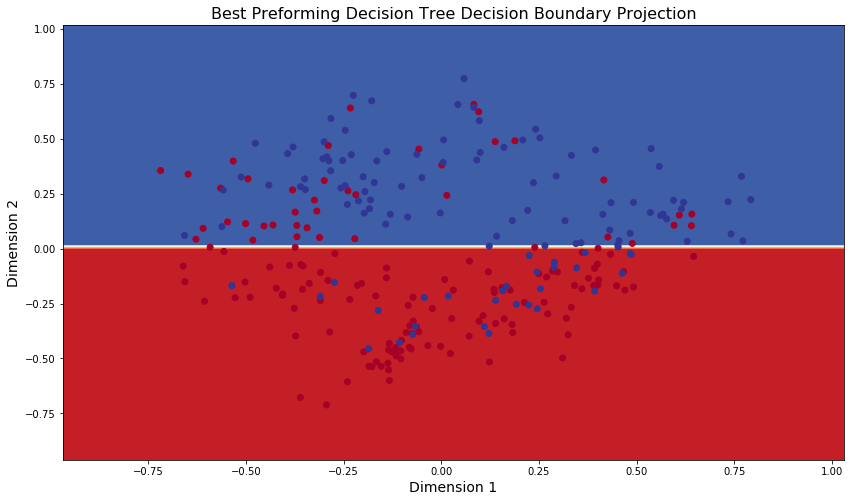

In [62]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Best Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()


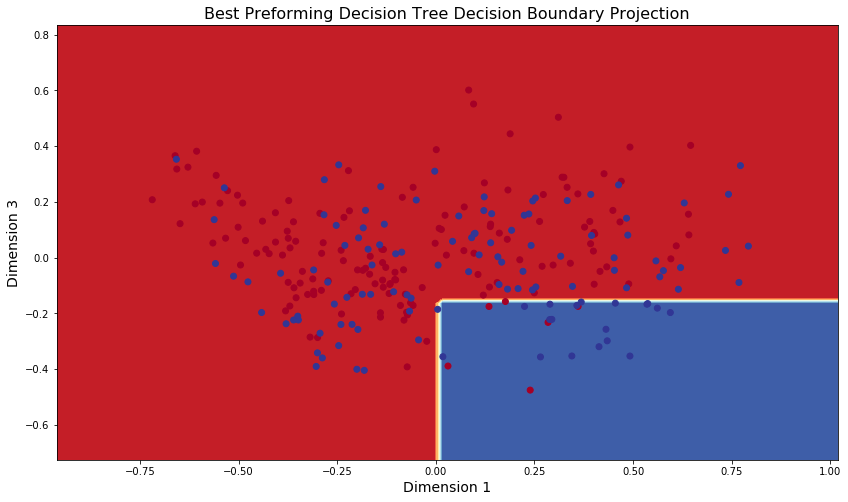

In [63]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()

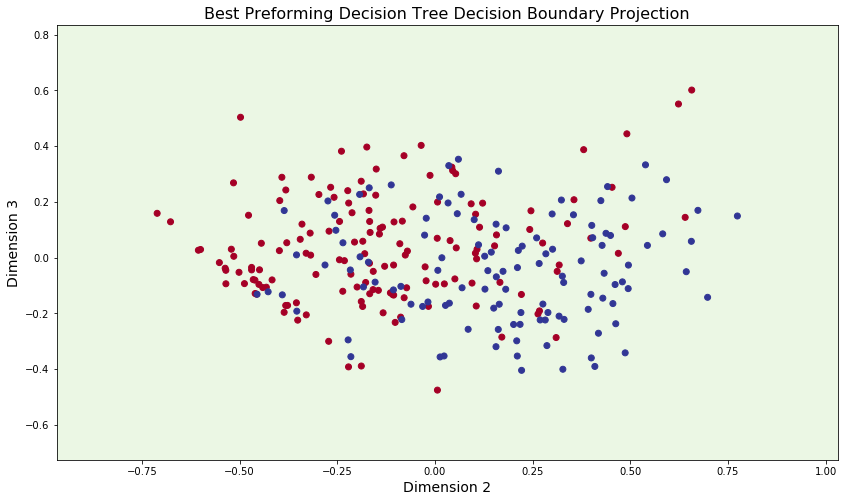

In [64]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[4]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()


Plot worst decision tree decision boundary. Using the same code as above cells but replacing gridObjsDecTree[4] with [2] corresponding to my worst result.

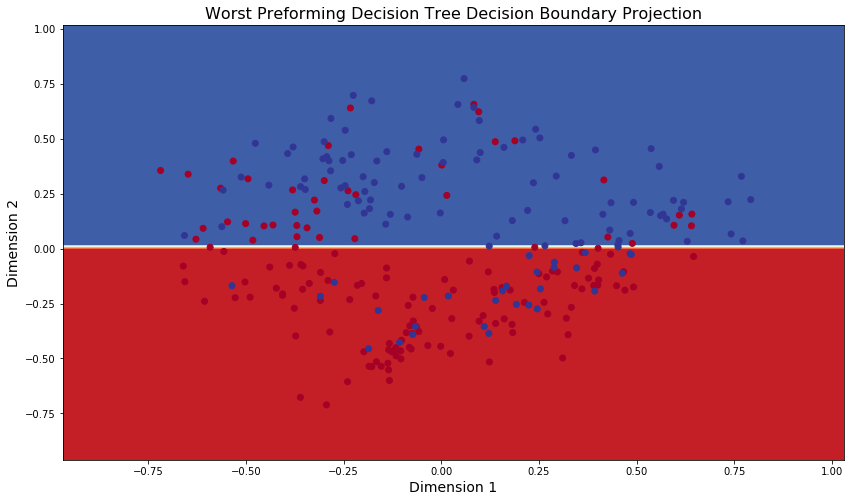

In [76]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Worst Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()

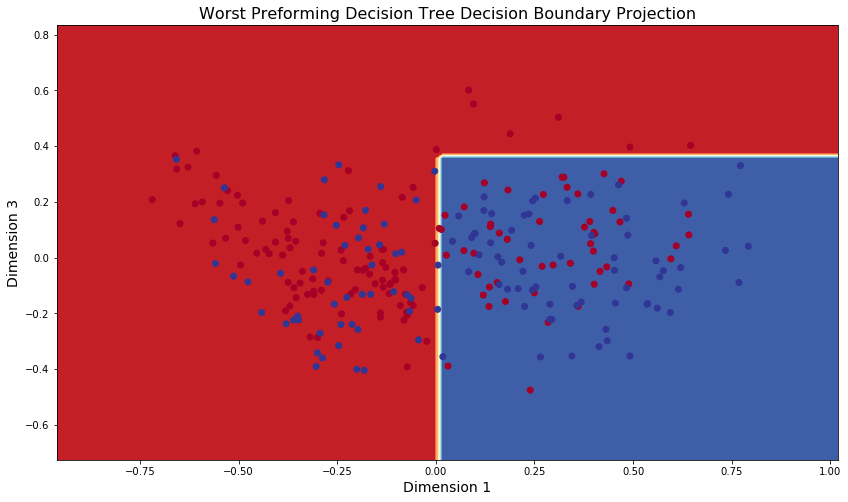

In [77]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()

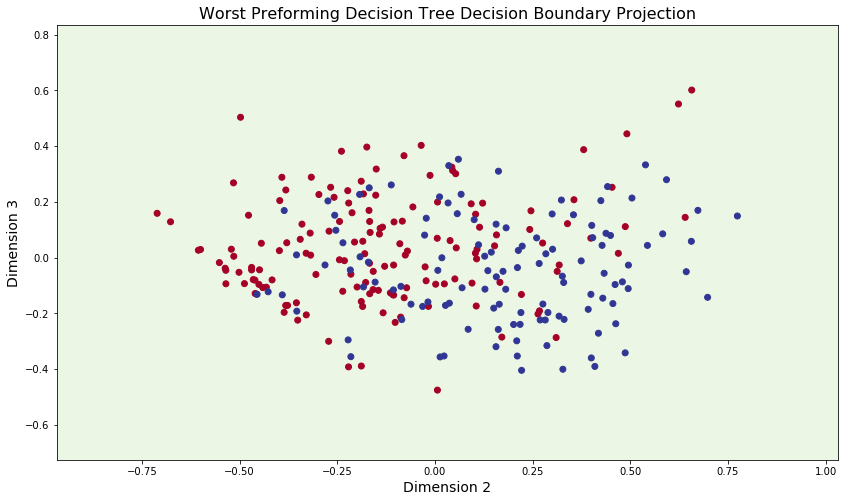

In [78]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestRawTree=gridObjsDecTree[2]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestRawTree.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Decision Tree Decision Boundary Projection", fontsize=16);
plt.show()


## Random Forest Sklearn

Repeating code from above but with best and worst random forest models

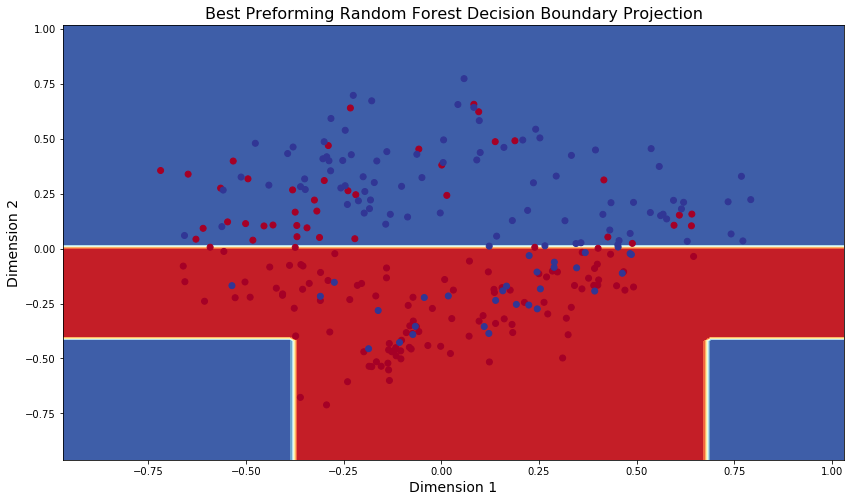

In [66]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Best Preforming Random Forest Decision Boundary Projection", fontsize=16);
plt.show()


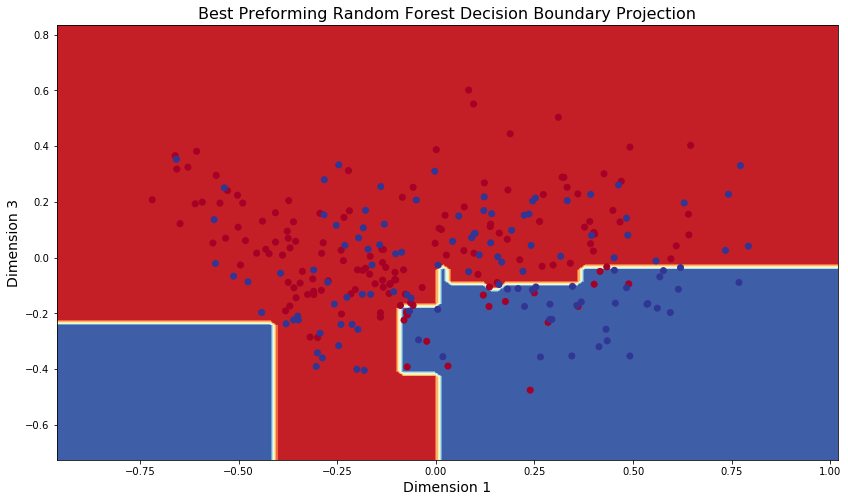

In [67]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[4]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()

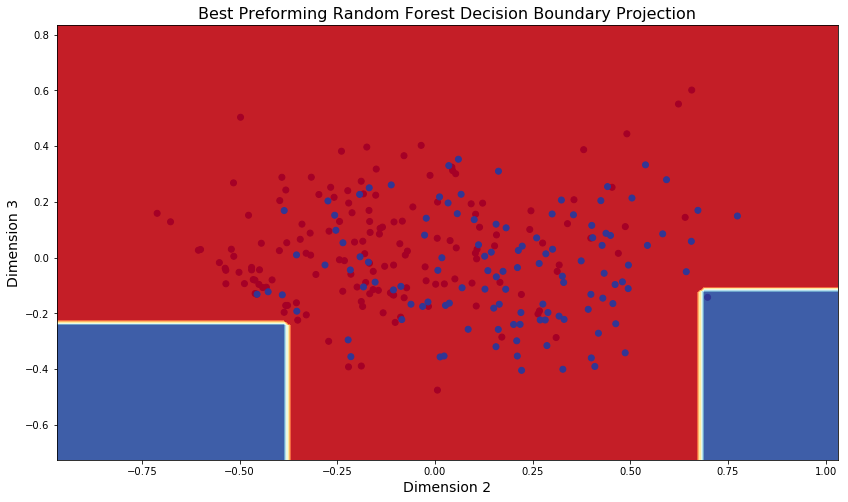

In [69]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[4]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Best Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()


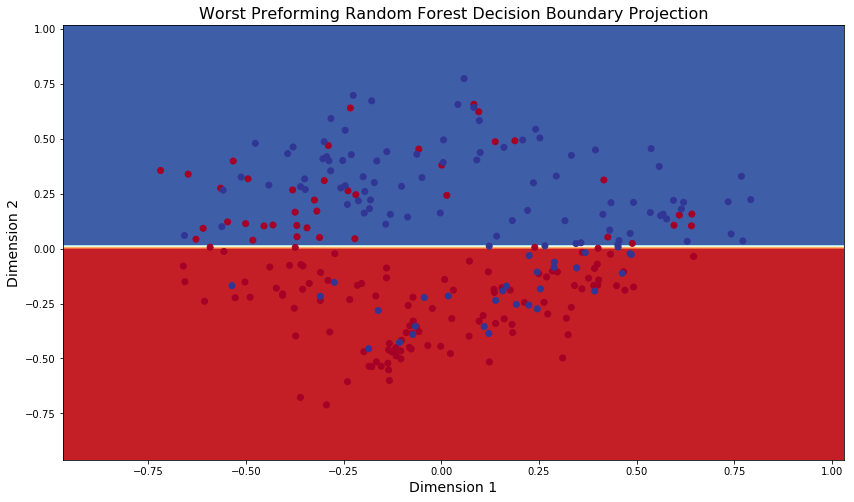

In [79]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1,)
ax.contourf(xx[:,:,0],yy[:,:,0], Z[:,:,0], cmap=plt.cm.RdYlBu)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("Worst Preforming Random Forest Decision Boundary Projection", fontsize=16);
plt.show()

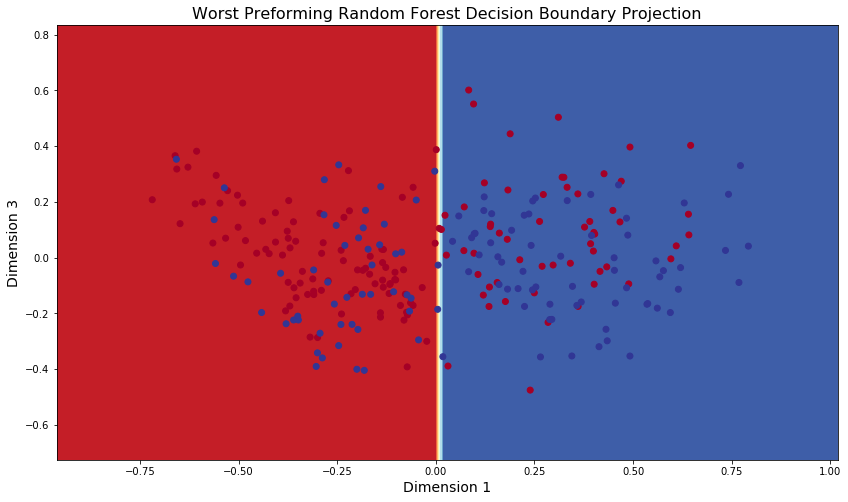

In [80]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[2]

#meshgrid step
h=0.02

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)
ax.contourf(yy[:,0,:],zz[:,0,:], Z[:,0,:], cmap=plt.cm.RdYlBu)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()

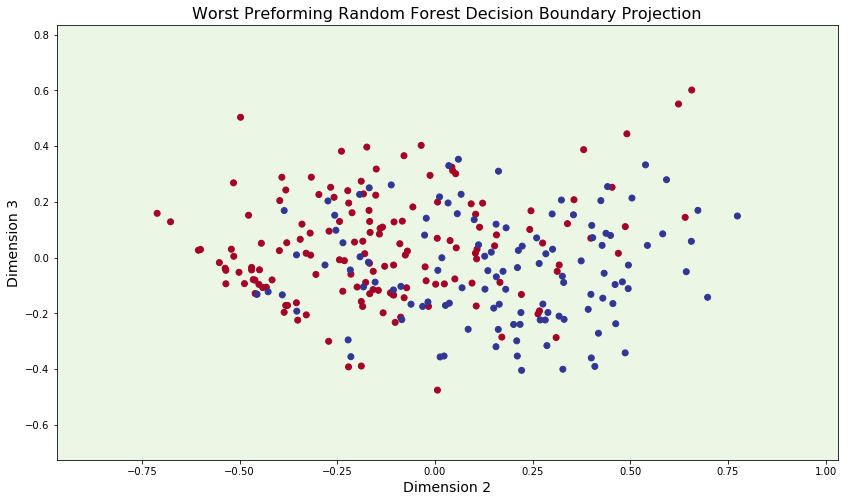

In [81]:
#Copy feature array
X=np.array(XPCAgood_dataRed3d)
#meshgrid step
h=0.02

#Copy of best Decision Tree on Raw Inputs
bestForest=gridObjsForest[2]

#Create grid bounds
x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
z_min, z_max = X[:,2].min() - 0.25, X[:,2].max() + 0.25
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h),
                        np.arange(z_min, z_max, h))

# here "model" is your model's prediction (classification) function
Z = bestForest.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) 
['r' if x==1 else 'b' for x in Z]
# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize= (14,8))

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1)

ax.contourf(xx[0,:,:],zz[0,:,:], Z[0,:,:], cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 1], X[:, 2], c=Ygoodarray, cmap=plt.cm.RdYlBu)

#Set Title and Labels
ax.set_xlabel("Dimension 2", fontsize=14)
ax.set_ylabel("Dimension 3", fontsize=14)
ax.set_title("Worst Preforming Random Forest Decision Boundary Projection", fontsize=16);

plt.show()
